In [1]:
import os
import cv2
import numpy as np

data_folder = "/public/home/xiaojx/age/age_estimation/data/utkface_aligned_cropped/UTKFace"
X_train = []
y_age_train = []

for filename in os.listdir(data_folder):
    if filename.endswith('.jpg'):
        # Extract the age
        age = filename[:-4].split('_')[0]
        # Load the image using OpenCV
        image_path = os.path.join(data_folder, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Append the image and age label to the lists
        X_train.append(image)
        y_age_train.append(int(age))

# Convert the lists to numpy arrays
X_train = np.array(X_train)
y_age_train = np.array(y_age_train)

# Print the shape of the arrays
print('Xtrain shape:', X_train.shape)
print('ytrain shape:', y_age_train.shape)

Xtrain shape: (23708, 200, 200, 3)
ytrain shape: (23708,)


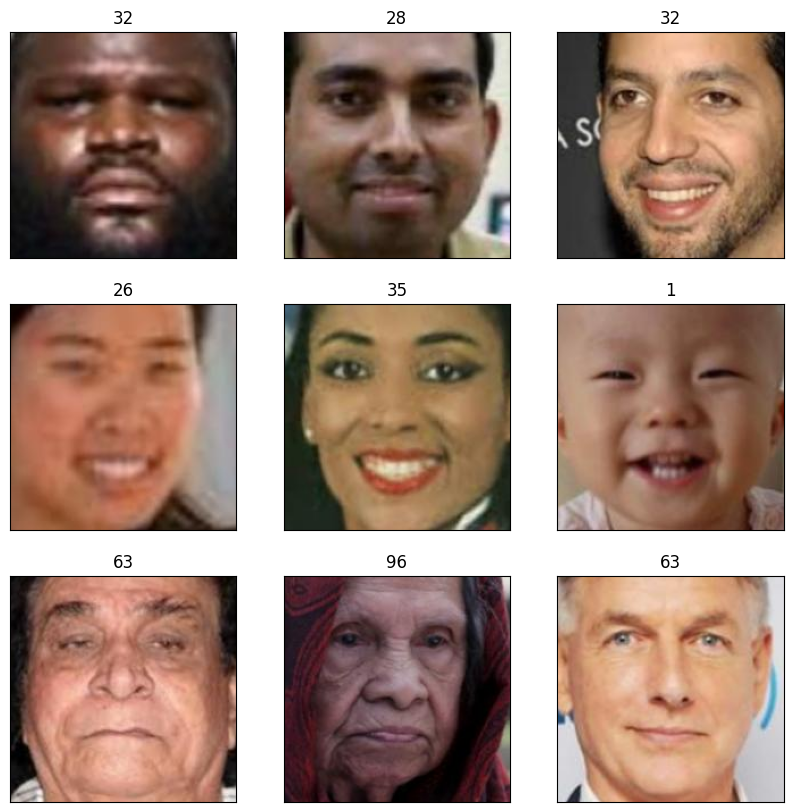

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9):
    x = np.random.randint(0, len(X_train))
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[x])
    plt.title(y_age_train[x])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [3]:
"""
create a new label named y_age_stage
Infant and Toddler: 0-3 years   class = 0
Preschooler and Kindergartener: 4-6 years  class = 1
child: 7-12 years class = 2
adolescent: 13-21 years class = 3
Adult in the prime : 22-37 years class = 4
Middle adult: 38-65 years class = 5
Elderly: 66-84 years class = 6
Oldest old: 85 years and older class = 7
"""
def map_age_stage(age):
    if age <= 3:
        return 0
    elif age <= 6:
        return 1
    elif age <= 12:
        return 2
    elif age <= 21:
        return 3
    elif age <= 37:
        return 4
    elif age <= 65:
        return 5
    elif age <= 84:
        return 6
    else:
        return 7

y_stage_train = np.array([map_age_stage(age) for age in y_age_train])

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_stage_train, test_size=0.15, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (20151, 200, 200, 3)
Train labels shape:  (20151,)
Validation data shape:  (2845, 200, 200, 3)
Validation labels shape:  (2845,)
Test data shape:  (712, 200, 200, 3)
Test labels shape:  (712,)


In [5]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 120000) (500, 120000)


In [6]:
from classifiers import KNearestNeighbor

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [7]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
k_accuracy = {}
for k in k_choices:
    print(k)
    knn = KNeighborsClassifier(n_neighbors=k)
    X_train_np = X_train.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    knn.fit(X_train_np, y_train_np)
    X_test_np = X_test.cpu().numpy()
    y_pred = knn.predict(X_test_np)
    accuracy = accuracy_score(y_test, y_pred)
    k_accuracy[k] = accuracy
    print(accuracy)
for k in sorted(k_accuracy):
    print('k = %d, MAE = %f' % (k, k_accuracy[k]))

1
0.394
3
0.38
5
0.468
8
0.48
10
0.488
12
0.484
15
0.468
20
0.478
50
0.49
100
0.51
k = 1, MAE = 0.394000
k = 3, MAE = 0.380000
k = 5, MAE = 0.468000
k = 8, MAE = 0.480000
k = 10, MAE = 0.488000
k = 12, MAE = 0.484000
k = 15, MAE = 0.468000
k = 20, MAE = 0.478000
k = 50, MAE = 0.490000
k = 100, MAE = 0.510000
